# Demo File
uitleg wat er in dit demo file gebeurt

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from ESN import EchoStateNetwork
from ESN import mackey_glass

# Naam van deze chapter
uitleg

In [14]:
# Generate Mackey-Glass time series
mg_series = mackey_glass(tau=17, n=10000, n_samples=5000)

# Normalize data between -1 and 1
mg_series = 2 * (mg_series - mg_series.min()) / (mg_series.max() - mg_series.min()) - 1

# Create input/output pairs for time series prediction
inputs = mg_series[:-1].reshape(-1, 1)
targets = mg_series[1:].reshape(-1, 1)

# Split into train and test sets
train_len = 3000
test_len = 1000
train_inputs = inputs[:train_len]
train_targets = targets[:train_len]
test_inputs = inputs[train_len:train_len+test_len]
test_targets = targets[train_len:train_len+test_len]

# Initialize and train ESN
esn = EchoStateNetwork(
    input_dim=1,
    reservoir_size=200,  # Larger reservoir for complex dynamics
    output_dim=1,
    a=1,
    d=0.3,
    c=1,
    spectral_radius=1.2, # Slightly above 1 for chaotic systems
    sparsity=0.85,       # More sparse connections
    input_scaling=0.5,   # Reduced input scaling
    regularization=1e-6
)

In [ ]:
# Train on first part of series
esn.fit(train_inputs, train_targets, washout=200)

# Generate predictions on test set
predictions = esn.predict(test_inputs)

In [15]:
# Calculate prediction error
mse = np.mean((predictions - test_targets)**2)
print(f"Test MSE: {mse:.5f}")

Test MSE: 0.00094


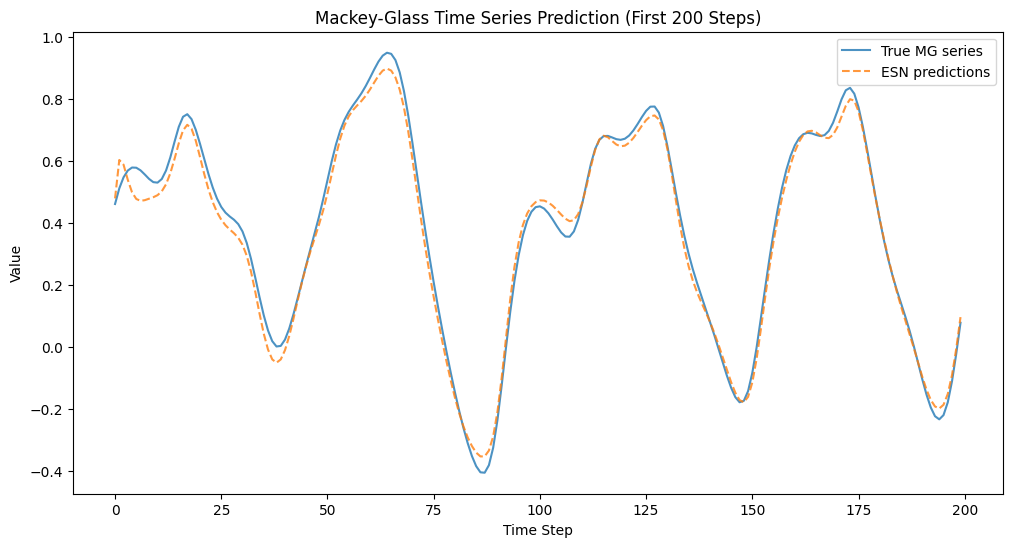

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(test_targets[:200], label='True MG series', alpha=0.8)
plt.plot(predictions[:200], label='ESN predictions', linestyle='--', alpha=0.8)
plt.title("Mackey-Glass Time Series Prediction (First 200 Steps)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()

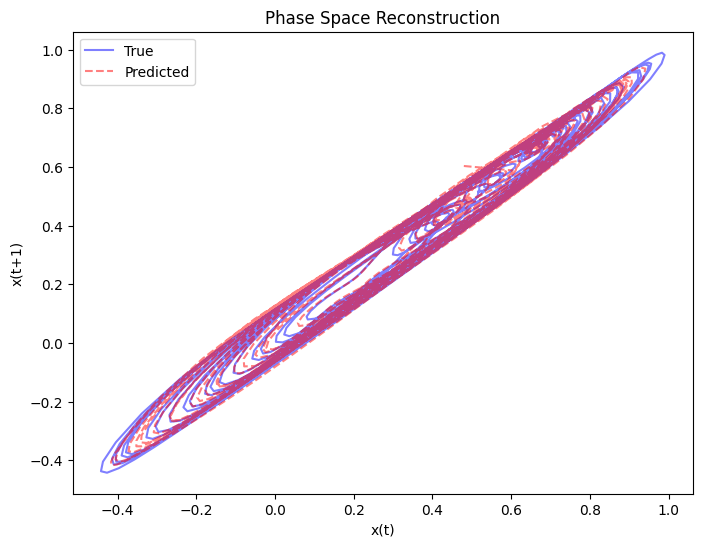

In [17]:
# Plot phase space reconstruction
plt.figure(figsize=(8, 6))
plt.plot(test_targets[:-1], test_targets[1:], 'b-', alpha=0.5, label='True')
plt.plot(predictions[:-1], predictions[1:], 'r--', alpha=0.5, label='Predicted')
plt.title("Phase Space Reconstruction")
plt.xlabel("x(t)")
plt.ylabel("x(t+1)")
plt.legend()
plt.show()

## uitleg
uitleg

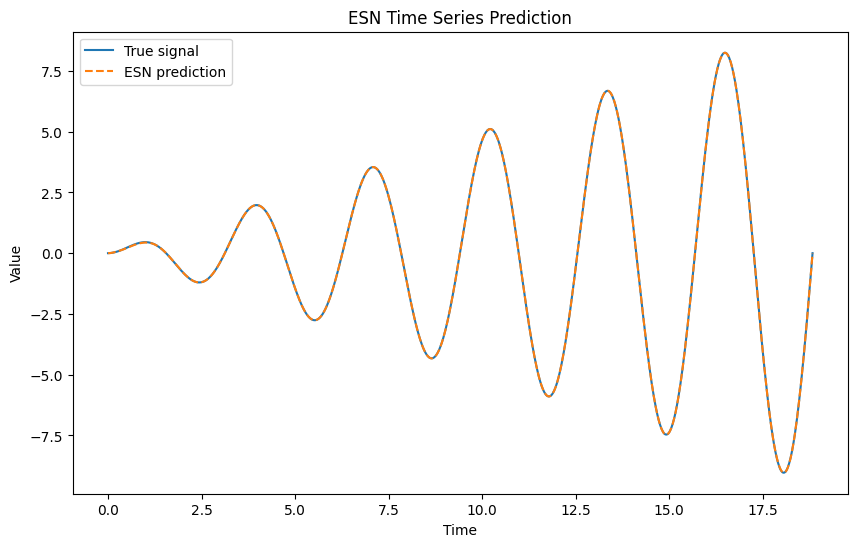

In [ ]:
# Generate synthetic data (simple sine wave prediction)
t = np.linspace(0, 6*np.pi, 1000)
data = np.sin(t)*np.cos(t)*t

# Create input/output pairs for time series prediction
inputs = data[:-1].reshape(-1, 1)
targets = data[1:].reshape(-1, 1)

# Initialize and train ESN
esn = EchoStateNetwork(
    input_dim=1,
    reservoir_size=100,
    output_dim=1,
    a=1,
    d=0.3,
    c=1,
    spectral_radius=0.95,
    sparsity=0.7,
    input_scaling=1.0,
    regularization=1e-4
)

In [ ]:
# Train on synthetic data
esn.fit(inputs, targets, washout=100)

# Generate predictions
predictions = esn.predict(inputs)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t[:-1], targets, label='True signal')
plt.plot(t[:-1], predictions, label='ESN prediction', linestyle='--')
plt.title("ESN Time Series Prediction")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()